# SEAL

SEAL is our third GNN for link prediction. As opposed to the heuristics and latent-feature methods which serve as our baselines, it is capable of taking into account both the graph structure and the node features to correctly predict links. Specifically, SEAL leverages the information contained in subgraphs around a target link to predict this link.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.dataset_creation import LinkPredictionDataset

import json
import os
import os.path as osp
import time
import math
from itertools import chain

from scipy.sparse.csgraph import shortest_path
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression

import torch
from torch.nn import BCEWithLogitsLoss, Conv1d, MaxPool1d, ModuleList
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import MLP, GCNConv, global_sort_pool
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.data import Dataset, download_url
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import RandomLinkSplit 
from torch_geometric.utils import k_hop_subgraph, to_scipy_sparse_matrix

## Define helper functions

In [2]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [3]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

In [4]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].max()]

In [5]:
def print_best_hyperparameters(df, variable):
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].max()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean best validation average precision is:', df_best[variable].unique()[0])

In [6]:
def model_summary(model): 
    """
    Get a summary of the neural network/graph neural network.
    """
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [7]:
def plot_losses_and_accuracies(plot_type, df, index, spacing, filename, save):
    """
    Create the data frames required for plotting the losses and accuracies.
    """
    sns.set_style("whitegrid")  
    
    epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    epochs = [epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10]
    
    if plot_type == 'loss':
        loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        loss_df = [loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10]
        print_list = ['loss'] * 10
    elif plot_type == 'acc':
        acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        acc_df = [acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10]
        print_list = ['acc'] * 10
    elif plot_type == 'ap':
        ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        ap_df = [ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10]
        print_list = ['ap'] * 10
    elif plot_type == 'auc':
        auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        auc_df = [auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10]
        print_list = ['auc'] * 10
    
    for i in range(len(epochs)):
        epochs[i] = [k for k in range(1, 1+len(df['train_losses'][index][f"{i+1}"]))]
    
        if plot_type == 'loss':
            loss_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_losses'][index][f"{i+1}"], \
                                               df['val_losses'][index][f"{i+1}"], df['test_losses'][index][f"{i+1}"])), \
                                      columns = ['epoch', 'train_loss', 'val_loss', 'test_loss'])
            loss_df[i] = pd.melt(loss_df[i], id_vars=['epoch'], value_vars=['train_loss', 'val_loss', 'test_loss'])
        elif plot_type == 'acc':
            acc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_accs'][index][f"{i+1}"], \
                                              df['val_accs'][index][f"{i+1}"], df['test_accs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_acc', 'val_acc', 'test_acc'])
            acc_df[i] = pd.melt(acc_df[i], id_vars=['epoch'], value_vars=['train_acc', 'val_acc', 'test_acc'])
        elif plot_type == 'ap':
            ap_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aps'][index][f"{i+1}"], \
                                              df['val_aps'][index][f"{i+1}"], df['test_aps'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_ap', 'val_ap', 'test_ap'])
            ap_df[i] = pd.melt(ap_df[i], id_vars=['epoch'], value_vars=['train_ap', 'val_ap', 'test_ap'])
        elif plot_type == 'auc':
            auc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aucs'][index][f"{i+1}"], \
                                              df['val_aucs'][index][f"{i+1}"], df['test_aucs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_auc', 'val_auc', 'test_auc'])
            auc_df[i] = pd.melt(auc_df[i], id_vars=['epoch'], value_vars=['train_auc', 'val_auc', 'test_auc'])
        
    seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]
    
    fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    figs = [fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10]
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,24))
    
    axes_list = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1], axes[3,0], axes[3,1], axes[4,0], axes[4,1]]
    
    for j, seed in enumerate(seeds):
        if plot_type == 'loss':
            data = loss_df[j]
        elif plot_type == 'acc':
            data = acc_df[j]
        elif plot_type == 'ap':
            data = ap_df[j]
        elif plot_type == 'auc':
            data = auc_df[j]
        figs[j] = sns.lineplot(data=data, x="epoch", y="value", hue="variable", ax=axes_list[j]).set_title(f"Run {j + 1} with seed {seeds[j]}: {print_list[j]}/epoch", fontsize=16)
        axes_list[j].xaxis.set_major_locator(MultipleLocator(spacing))
    
    plt.tight_layout()
        
    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight') 

## Hyperparameter tuning

The subsequent implementation of SEAL is very complex. Therefore, the running time of SEAL is also extremely high. We only run seal for one hyperparameter combination. The hyperparameters and their respective values are given by:
* `num_hops`: specifies the maximum number of hops that a node is allowed to be away in order to be still part of the enclosing subgraph. Set to 2.
* `hidden_channels`: dimension of each convolutional layer in the DGCNN. Set to 32.
* `num_layers`: number of convolutional layers in the DGCNN. Set to 3.
* `learning_rate`: learning rate of the Adam optimizer. Set to 0.0001.
* `weight_decay`: L2 penalty added to the loss function to prevent overfitting. Set to 0.
* `patience`: number of epochs after which to stop the training process if no decrease in the validation loss has been observed in the meantime. Set to 3. 

In [2]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [9]:
class SEALDataset(InMemoryDataset):
    def __init__(self, dataset, num_hops, split='train'):
        self.data = dataset[0]
        self.num_hops = num_hops
        super().__init__(dataset.root)
        index = ['train', 'val', 'test'].index(split)
        self.data, self.slices = torch.load(self.processed_paths[index])

    @property
    def processed_file_names(self):
        return ['SEAL_train_data.pt', 'SEAL_val_data.pt', 'SEAL_test_data.pt']

    def process(self):
        transform = RandomLinkSplit(num_val=0.1, num_test=0.3,
                                    is_undirected=True, split_labels=True)
        train_data, val_data, test_data = transform(self.data)

        self._max_z = 0

        # Collect a list of subgraphs for training, validation and testing:
        train_pos_data_list = self.extract_enclosing_subgraphs(
            train_data.edge_index, train_data.pos_edge_label_index, 1)
        train_neg_data_list = self.extract_enclosing_subgraphs(
            train_data.edge_index, train_data.neg_edge_label_index, 0)

        val_pos_data_list = self.extract_enclosing_subgraphs(
            val_data.edge_index, val_data.pos_edge_label_index, 1)
        val_neg_data_list = self.extract_enclosing_subgraphs(
            val_data.edge_index, val_data.neg_edge_label_index, 0)

        test_pos_data_list = self.extract_enclosing_subgraphs(
            test_data.edge_index, test_data.pos_edge_label_index, 1)
        test_neg_data_list = self.extract_enclosing_subgraphs(
            test_data.edge_index, test_data.neg_edge_label_index, 0)

        # Convert node labeling to one-hot features.
        for data in chain(train_pos_data_list, train_neg_data_list,
                          val_pos_data_list, val_neg_data_list,
                          test_pos_data_list, test_neg_data_list):
            # We solely learn links from structure, dropping any node features:
            data.x = F.one_hot(data.z, self._max_z + 1).to(torch.float)

        torch.save(self.collate(train_pos_data_list + train_neg_data_list),
                   self.processed_paths[0])
        torch.save(self.collate(val_pos_data_list + val_neg_data_list),
                   self.processed_paths[1])
        torch.save(self.collate(test_pos_data_list + test_neg_data_list),
                   self.processed_paths[2])

    def extract_enclosing_subgraphs(self, edge_index, edge_label_index, y):
        data_list = []
        for src, dst in edge_label_index.t().tolist():
            sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
                [src, dst], self.num_hops, edge_index, relabel_nodes=True)
            src, dst = mapping.tolist()

            # Remove target link from the subgraph.
            mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
            mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
            sub_edge_index = sub_edge_index[:, mask1 & mask2]

            # Calculate node labeling.
            z = self.drnl_node_labeling(sub_edge_index, src, dst,
                                        num_nodes=sub_nodes.size(0))

            data = Data(x=self.data.x[sub_nodes], z=z,
                        edge_index=sub_edge_index, y=y)
            data_list.append(data)

        return data_list

    def drnl_node_labeling(self, edge_index, src, dst, num_nodes=None):
        # Double-radius node labeling (DRNL).
        src, dst = (dst, src) if src > dst else (src, dst)
        adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).tocsr()

        idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
        adj_wo_src = adj[idx, :][:, idx]

        idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
        adj_wo_dst = adj[idx, :][:, idx]

        dist2src = shortest_path(adj_wo_dst, directed=False, unweighted=True,
                                 indices=src)
        dist2src = np.insert(dist2src, dst, 0, axis=0)
        dist2src = torch.from_numpy(dist2src)

        dist2dst = shortest_path(adj_wo_src, directed=False, unweighted=True,
                                 indices=dst - 1)
        dist2dst = np.insert(dist2dst, src, 0, axis=0)
        dist2dst = torch.from_numpy(dist2dst)

        dist = dist2src + dist2dst
        dist_over_2, dist_mod_2 = dist // 2, dist % 2

        z = 1 + torch.min(dist2src, dist2dst)
        z += dist_over_2 * (dist_over_2 + dist_mod_2 - 1)
        z[src] = 1.
        z[dst] = 1.
        z[torch.isnan(z)] = 0.

        self._max_z = max(int(z.max()), self._max_z)

        return z.to(torch.long)

In [10]:
class DGCNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, GNN=GCNConv, k=0.6):
        super().__init__()

        if k < 1:  # Transform percentile to number.
            num_nodes = sorted([data.num_nodes for data in train_dataset])
            k = num_nodes[int(math.ceil(k * len(num_nodes))) - 1]
            k = max(10, k)
        self.k = int(k)

        self.convs = ModuleList()
        self.convs.append(GNN(train_dataset.num_features, hidden_channels))
        for i in range(0, num_layers - 1):
            self.convs.append(GNN(hidden_channels, hidden_channels))
        self.convs.append(GNN(hidden_channels, 1))

        conv1d_channels = [16, 32]
        total_latent_dim = hidden_channels * num_layers + 1
        conv1d_kws = [total_latent_dim, 5]
        self.conv1 = Conv1d(1, conv1d_channels[0], conv1d_kws[0],
                            conv1d_kws[0])
        self.maxpool1d = MaxPool1d(2, 2)
        self.conv2 = Conv1d(conv1d_channels[0], conv1d_channels[1],
                            conv1d_kws[1], 1)
        dense_dim = int((self.k - 2) / 2 + 1)
        dense_dim = (dense_dim - conv1d_kws[1] + 1) * conv1d_channels[1]
        self.mlp = MLP([dense_dim, 128, 1], dropout=0.5, batch_norm=False)

    def forward(self, x, edge_index, batch):
        xs = [x]
        for conv in self.convs:
            xs += [conv(xs[-1], edge_index).tanh()]
        x = torch.cat(xs[1:], dim=-1)

        # Global pooling.
        x = global_sort_pool(x, batch, self.k)
        x = x.unsqueeze(1)  # [num_graphs, 1, k * hidden]
        x = self.conv1(x).relu()
        x = self.maxpool1d(x)
        x = self.conv2(x).relu()
        x = x.view(x.size(0), -1)  # [num_graphs, dense_dim]

        return self.mlp(x)

In [11]:
def train():
    model.train()

    #total_loss = 0
    total_loss_train = 0
    total_loss_val = 0
    total_loss_test = 0
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out_train = model(data.x, data.edge_index, data.batch)
        loss_train = criterion(out_train.view(-1), data.y.to(torch.float))
        loss_train.backward()
        optimizer.step()
        total_loss_train += loss_train * data.num_graphs
        
    model.eval()
    
    for data in val_loader:
        data = data.to(device)
        out_val = model(data.x, data.edge_index, data.batch)
        loss_val = criterion(out_val.view(-1), data.y.to(torch.float))
        total_loss_val += loss_val * data.num_graphs
        
    for data in test_loader:
        data = data.to(device)
        out_test = model(data.x, data.edge_index, data.batch)
        loss_test = criterion(out_test.view(-1), data.y.to(torch.float))
        total_loss_test += loss_test * data.num_graphs
        
    return total_loss_train / len(train_dataset), total_loss_val / len(val_dataset), total_loss_test / len(test_dataset), out_train, out_val, out_test


@torch.no_grad()
def test():
    model.eval()   
        
    y_train_pred, y_train_true = [], []
    for data in train_loader:
        data = data.to(device)
        train_logits = model(data.x, data.edge_index, data.batch)
        y_train_pred.append(train_logits.view(-1).cpu())
        y_train_true.append(data.y.view(-1).cpu().to(torch.float))
        
    train_auc = roc_auc_score(torch.cat(y_train_true), torch.cat(y_train_pred))
    train_ap = average_precision_score(torch.cat(y_train_true), torch.cat(y_train_pred))
        
    y_val_pred, y_val_true = [], []
    for data in val_loader:
        data = data.to(device)
        val_logits = model(data.x, data.edge_index, data.batch)
        y_val_pred.append(val_logits.view(-1).cpu())
        y_val_true.append(data.y.view(-1).cpu().to(torch.float))
        
    val_auc = roc_auc_score(torch.cat(y_val_true), torch.cat(y_val_pred))
    val_ap = average_precision_score(torch.cat(y_val_true), torch.cat(y_val_pred))
        
    y_test_pred, y_test_true = [], []
    for data in test_loader:
        data = data.to(device)
        test_logits = model(data.x, data.edge_index, data.batch)
        y_test_pred.append(test_logits.view(-1).cpu())
        y_test_true.append(data.y.view(-1).cpu().to(torch.float))
        
    test_auc = roc_auc_score(torch.cat(y_test_true), torch.cat(y_test_pred))
    test_ap = average_precision_score(torch.cat(y_test_true), torch.cat(y_test_pred))
        
    return train_auc, val_auc, test_auc, train_ap, val_ap, test_ap

In [ ]:
start_time = time.time()

seal_results = pd.DataFrame(columns = ['parameters', 'train_losses', 'val_losses', 'test_losses', 'train_aucs', 'val_aucs', 
                                       'test_aucs', 'train_aps', 'val_aps', 'test_aps', 'best_train_losses', 'best_val_losses', 
                                       'best_test_losses', 'best_train_aucs', 'best_val_aucs', 'best_test_aucs', 
                                       'best_train_aps', 'best_val_aps', 'best_test_aps', 'mean_best_train_loss', 
                                       'mean_best_val_loss', 'mean_best_test_loss', 'mean_best_train_auc', 'mean_best_val_auc', 
                                       'mean_best_test_auc', 'mean_best_train_ap', 'mean_best_val_ap', 'mean_best_test_ap', 
                                       'std_best_train_loss', 'std_best_val_loss', 'std_best_test_loss', 'std_best_train_auc', 
                                       'std_best_val_auc', 'std_best_test_auc', 'std_best_train_ap', 'std_best_val_ap', 
                                       'std_best_test_ap'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

# Loops for hyperparameter tuning (with current choice of hyperparameters)
for num_hops in [2]:
    for hidden_channels in [32]:
        for num_layers in [3]:
            for learning_rate in [0.0001]:
                for weight_decay in [0]:
                    for patience in [3]: 
                
                        # Hyperparamter tuning

                        print(f'====================================================================================================\nParameter combination: {{num_hops: {num_hops}, hidden_channels: {hidden_channels}, num_layers: {num_layers}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

                        parameter_dict = dict({'num_hops': num_hops, 'hidden_channels': hidden_channels, 'num_layers': num_layers, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

                        loss_dict = dict()
                        val_loss_dict = dict()
                        test_loss_dict = dict()
                        train_auc_dict = dict()                        
                        val_auc_dict = dict()
                        test_auc_dict = dict()
                        train_ap_dict = dict()
                        val_ap_dict = dict()
                        test_ap_dict = dict()

                        best_train_loss_dict = dict()
                        best_val_loss_dict = dict()
                        best_test_loss_dict = dict()
                        best_train_auc_dict = dict()
                        best_val_auc_dict = dict()
                        best_test_auc_dict = dict()
                        best_train_ap_dict = dict()
                        best_val_ap_dict = dict()
                        best_test_ap_dict = dict()

                        for i, seed in enumerate(seeds): 

                            torch_geometric.seed_everything(seed)
                            
                            dataset = LinkPredictionDataset(root='data/') # , transform=RandomLinkSplit(num_val=0.1, num_test=0.3, is_undirected=True,split_labels=True, add_negative_train_samples=True)
                            
                            train_dataset = SEALDataset(dataset, num_hops=num_hops, split='train')
                            val_dataset = SEALDataset(dataset, num_hops=num_hops, split='val')
                            test_dataset = SEALDataset(dataset, num_hops=num_hops, split='test')

                            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
                            val_loader = DataLoader(val_dataset, batch_size=32)
                            test_loader = DataLoader(test_dataset, batch_size=32)
                            
                            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # BW: leave in
                            model = DGCNN(hidden_channels=hidden_channels, num_layers=num_layers).to(device)
                            optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
                            criterion = BCEWithLogitsLoss()
                            
                            loss_list = []
                            val_loss_list = []
                            test_loss_list = []
                            train_auc_list = []
                            val_auc_list = []
                            test_auc_list = []
                            train_ap_list = []
                            val_ap_list = []
                            test_ap_list = []

                            last_loss = 100
                            patience = patience 
                            trigger_times = 0

                            print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

                            for epoch in range(1, 101):
                                loss, val_loss, test_loss, out_train, out_val, out_test = train() 
                                train_auc, val_auc, test_auc, train_ap, val_ap, test_ap = test() 
                                loss_list += [loss.item()]
                                val_loss_list += [val_loss.item()]
                                test_loss_list += [test_loss.item()]
                                train_auc_list += [train_auc]
                                val_auc_list += [val_auc]
                                test_auc_list += [test_auc]
                                train_ap_list += [train_ap]                                
                                val_ap_list += [val_ap]
                                test_ap_list += [test_ap]

                                current_val_loss = val_loss

                                print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train auc: {train_auc:.4f}, val auc: {val_auc:.4f}, test auc: {test_auc:.4f}, train ap: {train_ap:.4f}, val ap: {val_ap:.4f}, test ap: {test_ap:.4f}')

                                if current_val_loss <= last_loss:
                                    current_best_train_loss = loss.item()
                                    current_best_val_loss = current_val_loss.item()
                                    current_best_test_loss = test_loss.item()
                                    current_best_train_auc = train_auc
                                    current_best_val_auc = val_auc
                                    current_best_test_auc = test_auc
                                    current_best_train_ap = train_ap
                                    current_best_val_ap = val_ap
                                    current_best_test_ap = test_ap

                                    trigger_times = 0
                                    print('Trigger times: 0')

                                    last_loss = current_val_loss

                                else: 
                                    trigger_times += 1
                                    print('Trigger times:', trigger_times)

                                    if trigger_times >= patience:
                                        print('Early stopping!')
                                        break

                            loss_dict.update({f"{i+1}": loss_list}) 
                            val_loss_dict.update({f"{i+1}": val_loss_list}) 
                            test_loss_dict.update({f"{i+1}": test_loss_list}) 
                            train_auc_dict.update({f"{i+1}": train_auc_list}) 
                            val_auc_dict.update({f"{i+1}": val_auc_list}) 
                            test_auc_dict.update({f"{i+1}": test_auc_list}) 
                            train_ap_dict.update({f"{i+1}": train_ap_list}) 
                            val_ap_dict.update({f"{i+1}": val_ap_list}) 
                            test_ap_dict.update({f"{i+1}": test_ap_list}) 

                            best_train_loss_dict.update({f"{i+1}": current_best_train_loss}) 
                            best_val_loss_dict.update({f"{i+1}": current_best_val_loss}) 
                            best_test_loss_dict.update({f"{i+1}": current_best_test_loss}) 
                            best_train_auc_dict.update({f"{i+1}": current_best_train_auc}) 
                            best_val_auc_dict.update({f"{i+1}": current_best_val_auc})
                            best_test_auc_dict.update({f"{i+1}": current_best_test_auc}) 
                            best_train_ap_dict.update({f"{i+1}": current_best_train_ap}) 
                            best_val_ap_dict.update({f"{i+1}": current_best_val_ap})
                            best_test_ap_dict.update({f"{i+1}": current_best_test_ap}) 

                            print(current_best_val_loss)

                        data_concat = [{'parameters': parameter_dict, 'train_losses': loss_dict, 'val_losses': val_loss_dict, 
                                        'test_losses': test_loss_dict, 'train_aucs': train_auc_dict, 'val_aucs': val_auc_dict, 
                                        'test_aucs': test_auc_dict, 'train_aps': train_ap_dict, 'val_aps': val_ap_dict, 
                                        'test_aps': test_ap_dict, 'best_train_losses': best_train_loss_dict, 
                                        'best_val_losses': best_val_loss_dict, 'best_test_losses': best_test_loss_dict, 
                                        'best_train_aucs': best_train_auc_dict, 'best_val_aucs': best_val_auc_dict, 
                                        'best_test_aucs': best_test_auc_dict, 'best_train_aps': best_train_ap_dict, 
                                        'best_val_aps': best_val_ap_dict, 'best_test_aps': best_test_ap_dict, 
                                        'mean_best_train_loss': mean(best_train_loss_dict.values()), 
                                        'mean_best_val_loss': mean(best_val_loss_dict.values()), 
                                        'mean_best_test_loss': mean(best_test_loss_dict.values()), 
                                        'mean_best_train_auc': mean(best_train_auc_dict.values()), 
                                        'mean_best_val_auc': mean(best_val_auc_dict.values()), 
                                        'mean_best_test_auc': mean(best_test_auc_dict.values()),
                                        'mean_best_train_ap': mean(best_train_ap_dict.values()), 
                                        'mean_best_val_ap': mean(best_val_ap_dict.values()), 
                                        'mean_best_test_ap': mean(best_test_ap_dict.values()),
                                        'std_best_train_loss': std(best_train_loss_dict.values()), 
                                        'std_best_val_loss': std(best_val_loss_dict.values()), 
                                        'std_best_test_loss': std(best_test_loss_dict.values()), 
                                        'std_best_train_auc': std(best_train_auc_dict.values()), 
                                        'std_best_val_auc': std(best_val_auc_dict.values()), 
                                        'std_best_test_auc': std(best_test_auc_dict.values()),
                                        'std_best_train_ap': std(best_train_ap_dict.values()), 
                                        'std_best_val_ap': std(best_val_ap_dict.values()), 
                                        'std_best_test_ap': std(best_test_ap_dict.values())}]
                        df_concat = pd.DataFrame(data_concat)
                        seal_results = pd.concat([seal_results, df_concat], ignore_index=True)

print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to seal_results.pkl")
seal_results.to_pickle(f"{route0}/seal_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

In [3]:
# Look at results
seal_results = pd.read_pickle(f"{route0}/seal_results.pkl") 
seal_results

,parameters,train_losses,val_losses,test_losses,train_aucs,val_aucs,test_aucs,train_aps,val_aps,test_aps,best_train_losses,best_val_losses,best_test_losses,best_train_aucs,best_val_aucs,best_test_aucs,best_train_aps,best_val_aps,best_test_aps,mean_best_train_loss,mean_best_val_loss,mean_best_test_loss,mean_best_train_auc,mean_best_val_auc,mean_best_test_auc,mean_best_train_ap,mean_best_val_ap,mean_best_test_ap,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_auc,std_best_val_auc,std_best_test_auc,std_best_train_ap,std_best_val_ap,std_best_test_ap
0,"{'num_hops': 2, 'hidden_channels': 32, 'num_la...","{'1': [0.396357923746109, 0.31670132279396057,...","{'1': [0.34759965538978577, 0.3285880982875824...","{'1': [0.32305803894996643, 0.3027752637863159...","{'1': [0.9402360335688411, 0.9466061428508876,...","{'1': [0.9291694713099752, 0.9366800108643025,...","{'1': [0.9401223414933692, 0.9473878437902246,...","{'1': [0.9488060622499159, 0.9534232706469903,...","{'1': [0.9367609367946912, 0.9429137153039868,...","{'1': [0.944218855536936, 0.9504812950745941, ...","{'1': 0.15795773267745972, '2': 0.186451435089...","{'1': 0.1657237559556961, '2': 0.2079969346523...","{'1': 0.19123148918151855, '2': 0.205541953444...","{'1': 0.9865727658186775, '2': 0.9810749662292...","{'1': 0.9828769145380901, '2': 0.9743980349783...","{'1': 0.9799777990340217, '2': 0.9778167475584...","{'1': 0.9870357087718333, '2': 0.9816230689328...","{'1': 0.9837170440333788, '2': 0.9740920400612...","{'1': 0.9801990957102589, '2': 0.9768715577815...",0.183109,0.196555,0.204049,0.98159,0.97606,0.977114,0.982071,0.976252,0.976351,0.018037,0.023283,0.012339,0.003822,0.005346,0.003258,0.003784,0.005694,0.003447


## Best hyperparameter combination

In [13]:
filter_best_hyperparameters(seal_results, 'mean_best_val_ap')

,parameters,train_losses,val_losses,test_losses,train_aucs,val_aucs,test_aucs,train_aps,val_aps,test_aps,...,mean_best_test_ap,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_auc,std_best_val_auc,std_best_test_auc,std_best_train_ap,std_best_val_ap,std_best_test_ap
0,"{'num_hops': 2, 'hidden_channels': 32, 'num_la...","{'1': [0.396357923746109, 0.31670132279396057,...","{'1': [0.34759965538978577, 0.3285880982875824...","{'1': [0.32305803894996643, 0.3027752637863159...","{'1': [0.9402360335688411, 0.9466061428508876,...","{'1': [0.9291694713099752, 0.9366800108643025,...","{'1': [0.9401223414933692, 0.9473878437902246,...","{'1': [0.9488060622499159, 0.9534232706469903,...","{'1': [0.9367609367946912, 0.9429137153039868,...","{'1': [0.944218855536936, 0.9504812950745941, ...",...,0.976351,0.018037,0.023283,0.012339,0.003822,0.005346,0.003258,0.003784,0.005694,0.003447


In [14]:
print_best_hyperparameters(seal_results, 'mean_best_val_ap')

The best hyperparameter combination/s is/are:
	 {'num_hops': 2, 'hidden_channels': 32, 'num_layers': 3, 'learning_rate': 0.0001, 'weight_decay': 0, 'patience': 3} 
The resulting mean best validation average precision is: 0.9762523294599526


Of course, the "best" hyperparameter combination is given by the only one we considered. 

## Visualizations

We do not need to run the model again since we have all interesting results in our table. We instead only initialize the model to obtain a model summary.

In [15]:
# Initialization of model
num_hops = 2
hidden_channels = 32
num_layers = 3
learning_rate = 0.0001
weight_decay = 0
patience = 3
                
torch_geometric.seed_everything(12345) 
                            
dataset = LinkPredictionDataset(root='data/') 

train_dataset = SEALDataset(dataset, num_hops=num_hops, split='train')
val_dataset = SEALDataset(dataset, num_hops=num_hops, split='val')
test_dataset = SEALDataset(dataset, num_hops=num_hops, split='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = DGCNN(hidden_channels=hidden_channels, num_layers=num_layers).to(device)        

Processing...
Done!


To get a better impression of our model, let us look at a summary of our SEAL model.

In [16]:
model

DGCNN(
  (convs): ModuleList(
    (0): GCNConv(16, 32)
    (1): GCNConv(32, 32)
    (2): GCNConv(32, 32)
    (3): GCNConv(32, 1)
  )
  (conv1): Conv1d(1, 16, kernel_size=(97,), stride=(97,))
  (maxpool1d): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
  (mlp): MLP(3360, 128, 1)
)

In [17]:
model_summary(model)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
        convs.0.bias                       [32]              32
  convs.0.lin.weight                   [32, 16]             512
        convs.1.bias                       [32]              32
  convs.1.lin.weight                   [32, 32]            1024
        convs.2.bias                       [32]              32
  convs.2.lin.weight                   [32, 32]            1024
        convs.3.bias                        [1]               1
  convs.3.lin.weight                    [1, 32]              32
        conv1.weight                [16, 1, 97]            1552
          conv1.bias                       [16]              16
        conv2.weight                [32, 16, 5]            2560
          conv2.bias                       [32]              32
   mlp.lins.0.weight                [1

### Visualization of losses and metrics

Finally, we take a look at the losses and metrics in the training set, validation set and test set for the 10 runs for our single hyperparameter combination.

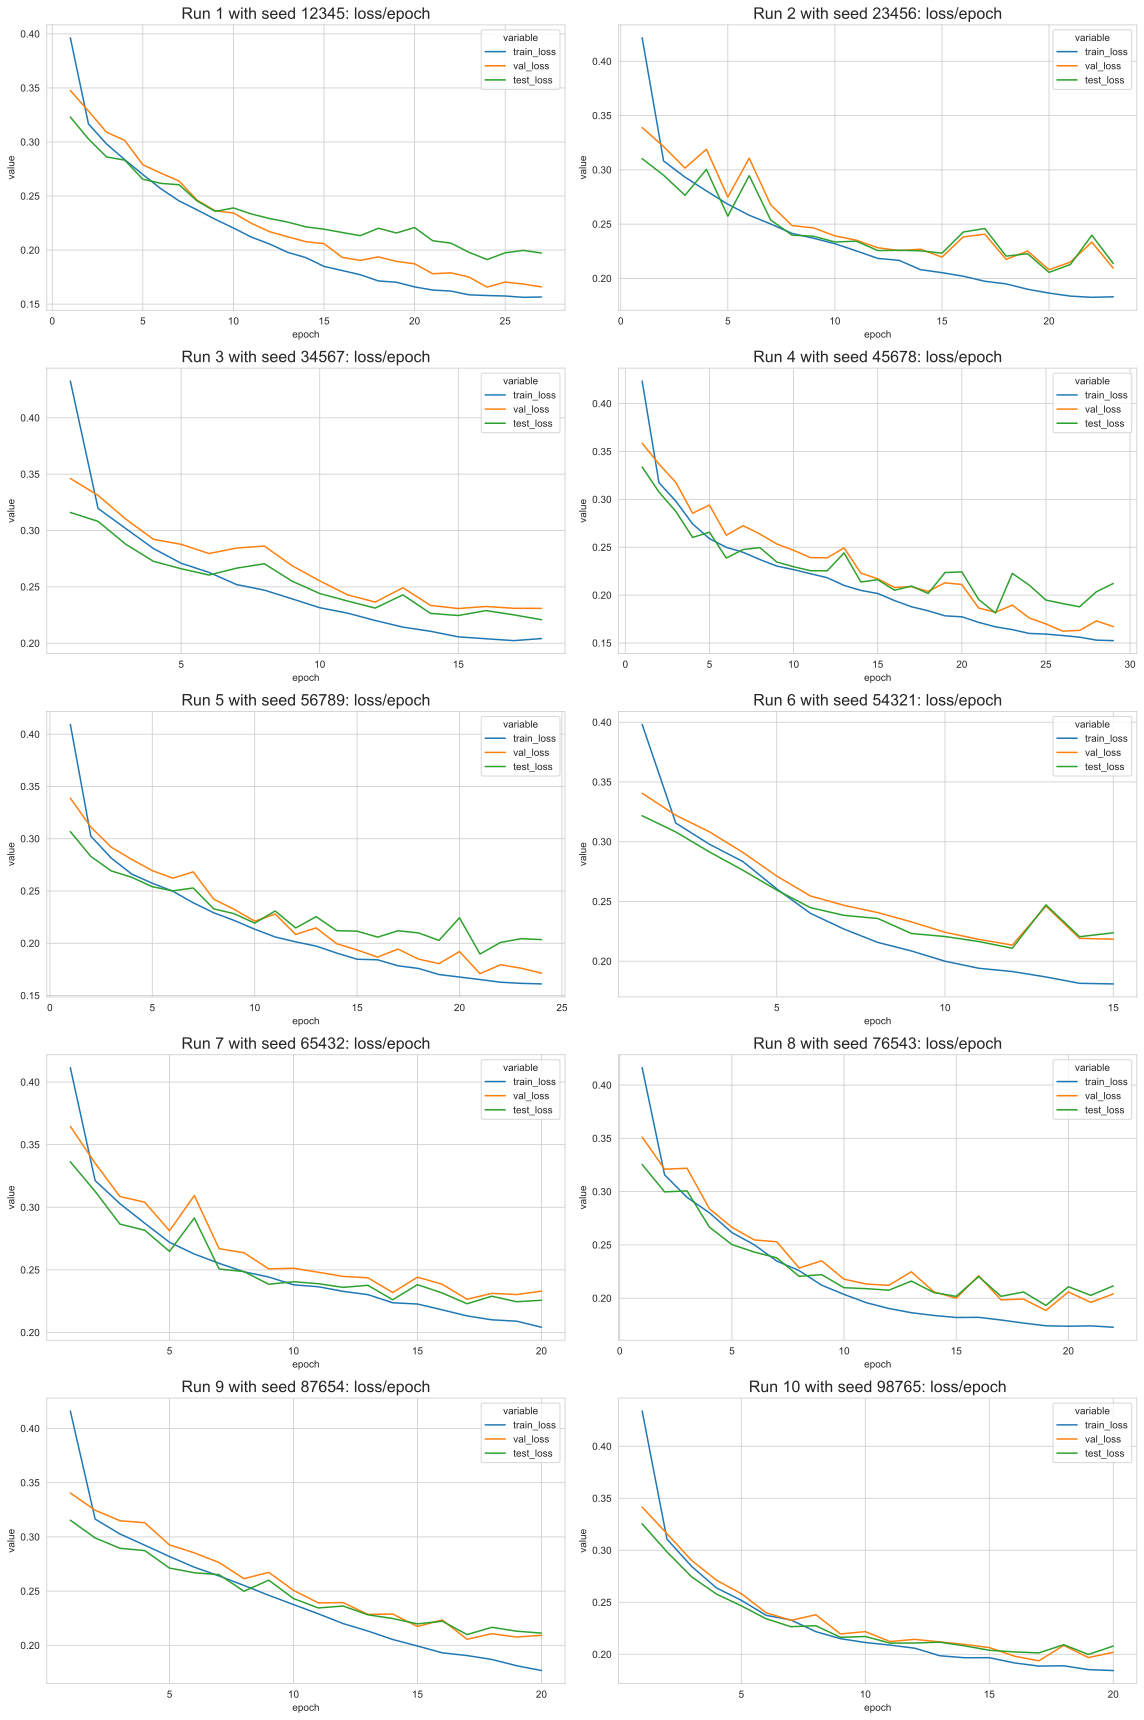

In [18]:
plot_losses_and_accuracies('loss', seal_results, 0, 5.0, 'seal_loss', True)

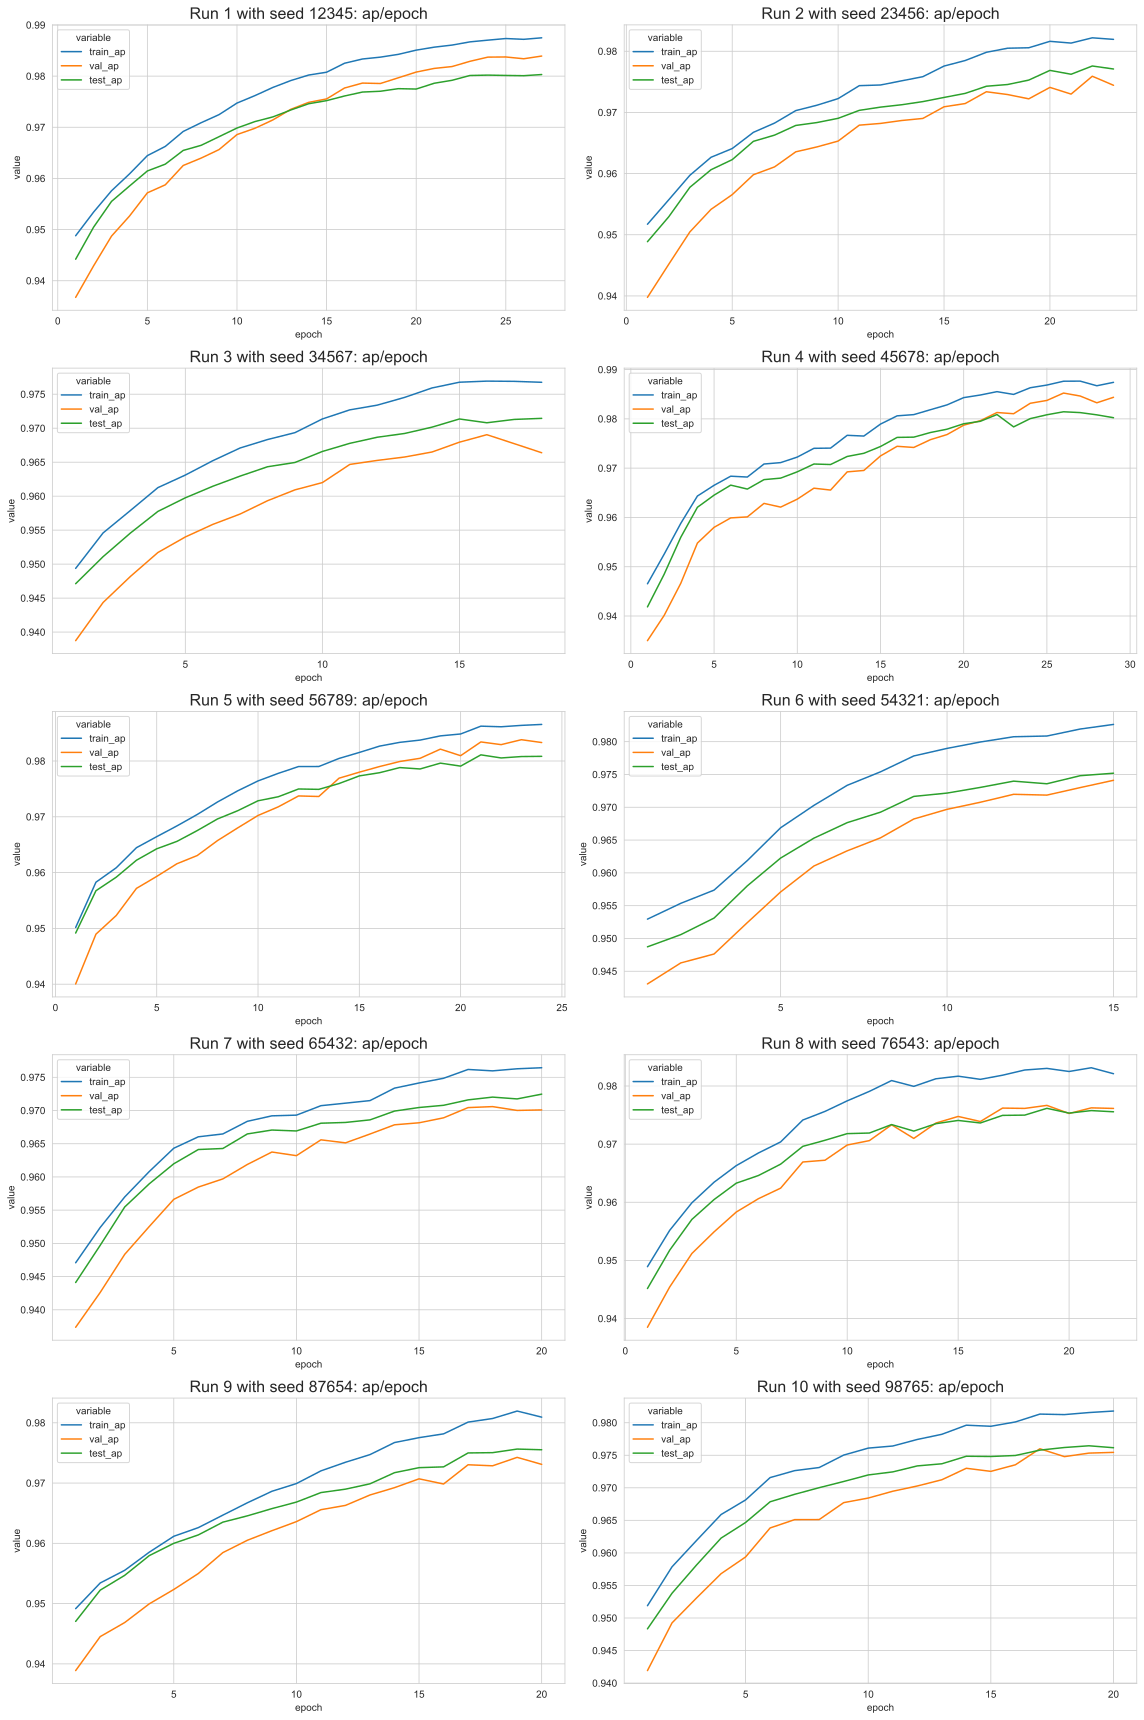

In [19]:
plot_losses_and_accuracies('ap', seal_results, 0, 5.0, 'seal_ap', True)

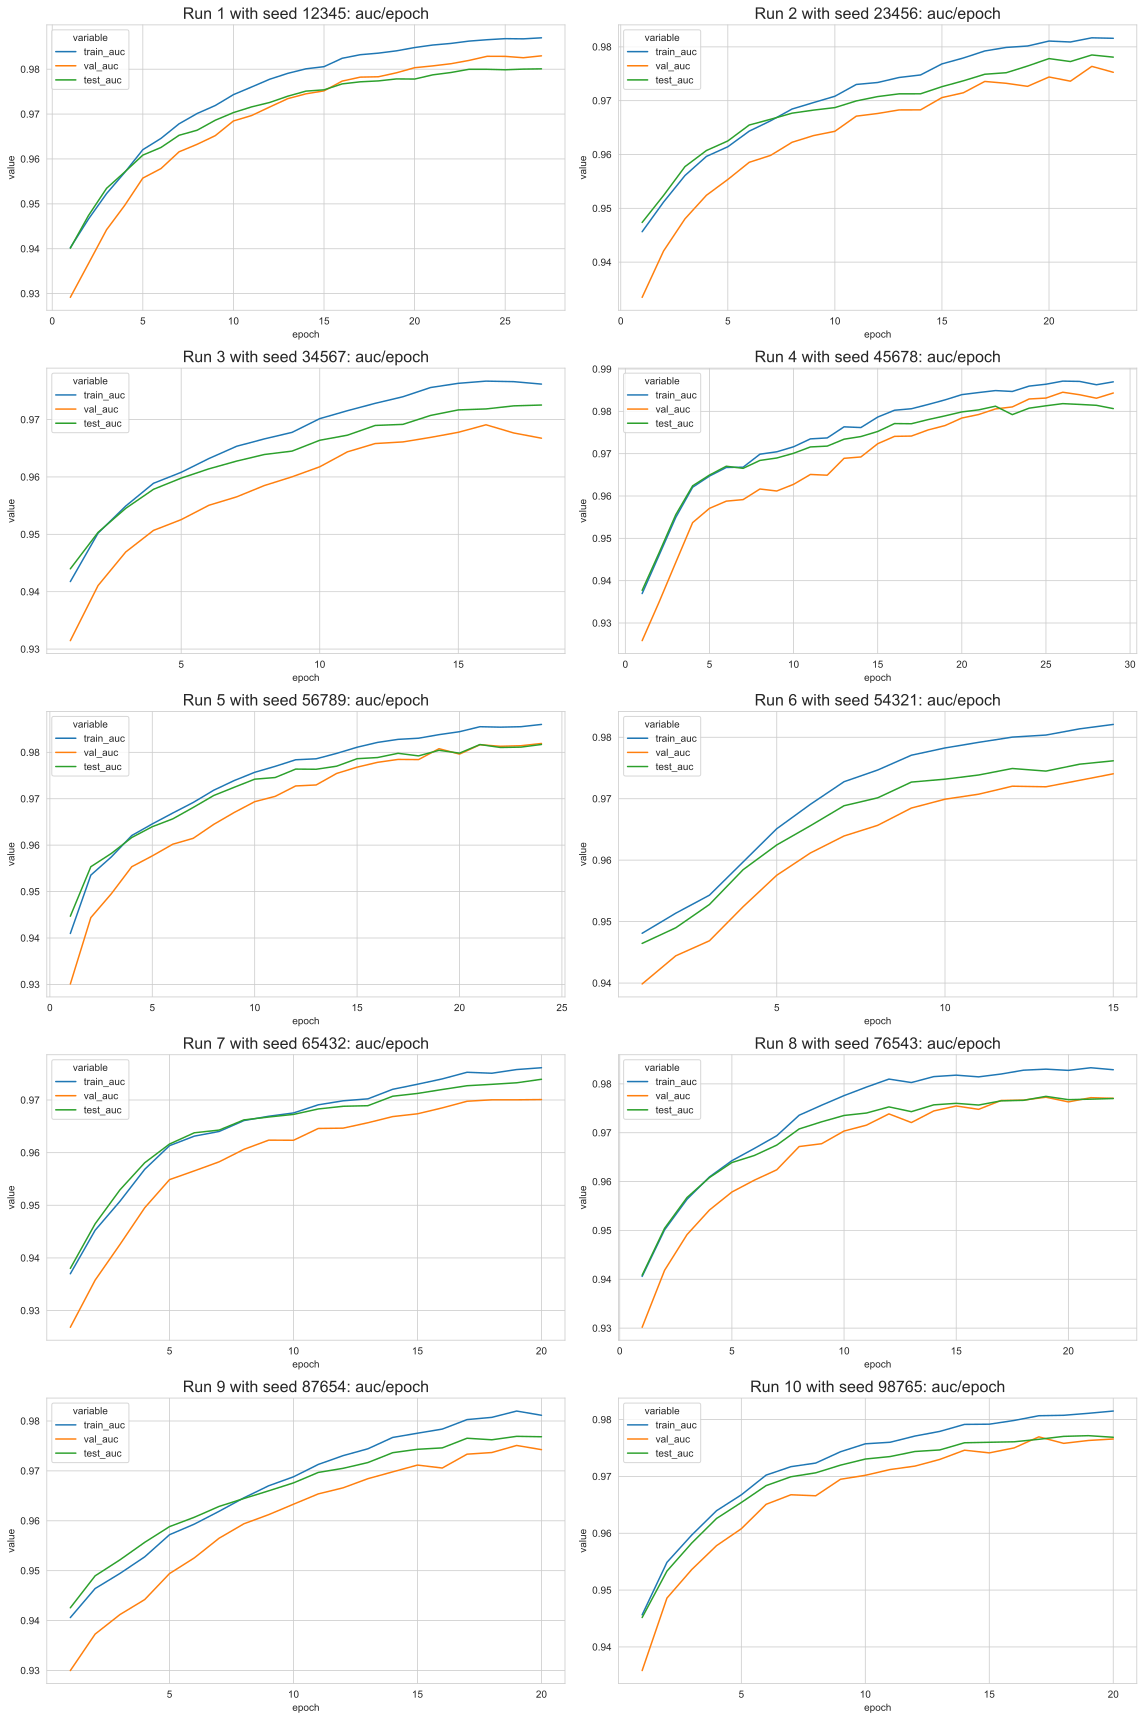

In [20]:
plot_losses_and_accuracies('auc', seal_results, 0, 5.0, 'seal_auc', True)